In [25]:
%matplotlib inline
import pyspeckit
import numpy as np
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from c_normalize import c_normalize
import glob
import pandas as pd
plt.style.use('seaborn-paper')

# Python-based Automation of Equivalent Width Measurement
Utilizing pyspeckit (https://pyspeckit.readthedocs.io/en/latest/) and a python port of Joleen Carlberg's (STScI) Continuum Normalization algorithm, this notebook seeks to set up and test an automated equivalent width measurement algorithm for a number of spectrum for which we have hand measurements. The expectations for this method are that 95% of the measurements are within 5% of our by-hand measurements.

### An Example
Before diving straight into scripting, it's useful to layout an individual example of the equivalent width measurement process.

The fit may be poorly conditioned


EQW: 141.52166728162004 mA


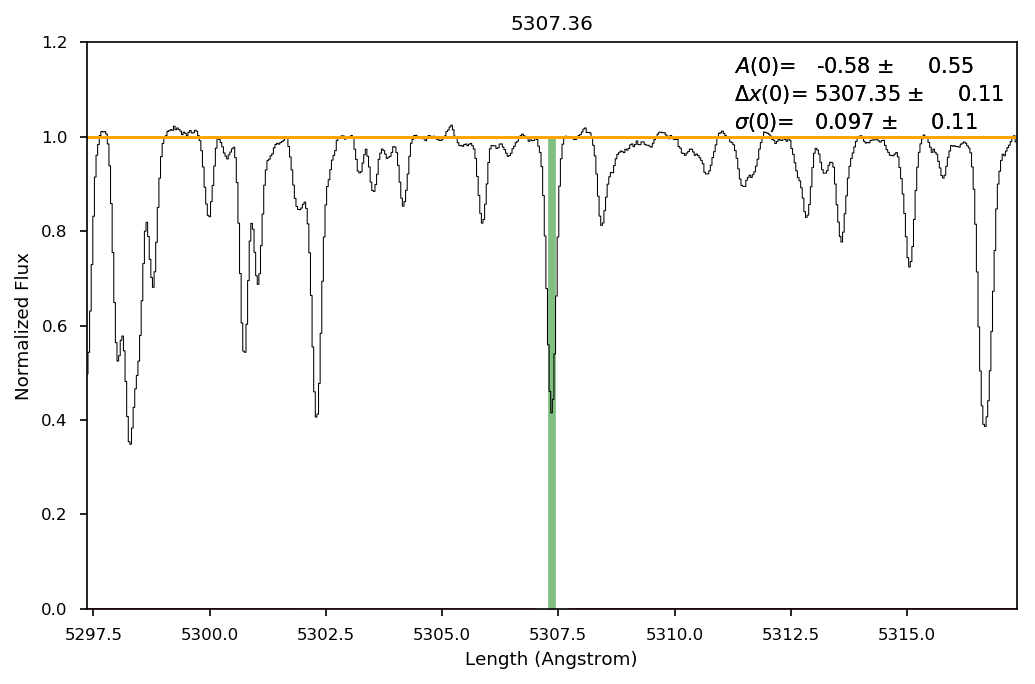

In [21]:
# Pull in an example spectrum
s_hdu = fits.open("Data/ew_known/tame_inputs/col110_1134red_oned_25jan14_wavsoln.fits")
fig = plt.figure(figsize=(8,5), dpi = 150)

# Grab the flux and wavelength arrays from the spectrum
s_data = s_hdu[1].data
s_flux = s_data['FLUX']
smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
s_flux = smoothed_flux
s_wav = s_data['WAVEL']

# Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
line_cen = 5307.36
width = 10
lim_l = line_cen - width
lim_r = line_cen + width

# Mask the flux and wavelength arrays based on the sampled wavelength range
wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
s_flux = s_flux[wav_mask]
s_wav = s_wav[wav_mask]

# Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.9)

# Load the normalized spectrum into a pyspeckit.Spectrum object
sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)
sp.plotter(figure = fig, xmin=lim_l, xmax=lim_r, ymin=0, ymax=1.2)

#Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
sp.baseline.basespec = np.ones(len(s_wav))

#Fit a gaussian to the line, this may be too simplistic for blended lines
sp.specfit(fittype='gaussian', guesses = [0.1, line_cen, 0.1])

#Measure the Equivalent Width of the gaussian line fit against the normalized baseline
EQW = sp.specfit.EQW(plot=True, continuum_as_baseline=True)
print("EQW:", EQW*1000*u.mA)
plt.axhline(1, color = 'orange')
plt.ylabel("Normalized Flux")
plt.title(str(line_cen))
#sp.plotter.savefig('basic_plot_example_withfit.png')

## Testing Consistency for a Line Across Multiple Spectrum
A crucial requirement for any automated equivalent width process is that it provides consistent results across the vast majority of spectrum for a given line.

In [27]:
# Select Datasets and extract equivalent widths
by_hand = glob.glob("tame-1.1.0/*.ew")

d = {'By-Hand File': by_hand}
disp_df = pd.DataFrame(data=d)
#disp_df